<a href="https://colab.research.google.com/github/harshad317/Auto_boost/blob/main/Auto_boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install catboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedKFold, KFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, log_loss
from sklearn.metrics import mean_squared_error, r2_score, auc, mean_absolute_error

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [5]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [6]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
[var for var in train.columns if train[var].dtypes == 'O']

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [9]:
cat_cols= [
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [10]:
[var for var in train.columns if train[var].dtypes != 'O']

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported']

In [11]:
cont_cols= ['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [25]:
target= train.Transported
#X_test= test

In [13]:
train.shape, test.shape

((8693, 14), (4277, 13))

In [15]:
class Auto_Boost():
  def __init__(self, train, test, target, algorithm):
    self.train= train
    self.test= test
    self.target= target
    self.algorithm= algorithm

  def fill_missing_values(self, X):
    #X= copy.deepcopy(X)
    for col in X.columns:
      if X[col].isnull().sum() > 0:
        print('We have column', col, 'with missing values', X[col].isnull().sum())
        if X[col].nunique() < 25 and X[col].dtypes !='O':
          X[col].fillna(X[col].mode()[0], axis= 0, inplace= True)
        elif X[col].nunique() > 25 and X[col].dtypes != 'O':
          X[col].fillna(X[col].median(), axis=0, inplace= True)
        elif X[col].nunique() < 25 and X[col].dtypes == 'O':
          X[col].fillna(X[col].mode()[0], axis= 0, inplace= True)
        elif X[col].nunique() > 25:
          X= X.drop(col, axis= 1)
      elif X[col].isnull().sum() == 0:
        None
    return X
  
  def categorical_columns(self, X):
    for col in [var for var in X.columns if X[var].dtypes =='O']:
      if X[col].nunique == 1:
        X = X.drop(col, axis= 1)
      elif X[col].nunique() <= 15:
        a= pd.get_dummies(X[col], drop_first=True, prefix=col)
        X= X.drop(col, axis= 1)
        X= pd.concat([X, a], axis=1)
      elif X[col].nunique()>15:
        le= LabelEncoder()
        le.fit(X[col])
        X[col]= le.transform(X[col])
    return X

  def creating_model(self, folds, model_type, random_state, X, target, metric, X_test):
    if model_type == 'Classification':
      skf= StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
      score = []

      for f, (train_idx, test_idx) in enumerate(skf.split(X, self.target)):
        print("="*15, "Fold No: ", f+1, "="*15)
        X_tr, X_tst= X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_tst= self.target.iloc[train_idx], self.target.iloc[test_idx]

        mod= self.algorithm
        mod.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=50, verbose=500)

        if metric== 'f1':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',f1_score(y_tst, preds))
          output= f1_score(y_tst, preds)
        elif metric== 'accuracy':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',accuracy_score(y_tst, preds))
          output= accuracy_score(y_tst, preds)
        elif metric== 'precision':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',precision_score(y_tst, preds))
          output= precision_score(y_tst, preds)
        elif metric== 'recall':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',recall_score(y_tst, preds))
          output= recall_score(y_tst, preds)
        elif metric== 'log_loss':
          preds= mod.predict_proba(X_tst)
          pred= mod.predict_proba(X_test)
          print('SCORE: ',log_loss(y_tst, preds))
          output= log_loss(y_tst, preds)
        elif metric== 'roc_auc':
          preds= mod.predict_proba(X_tst)
          pred= mod.predict_proba(X_test)
          print('SCORE: ',roc_auc_score(y_tst, preds[:,1]))
          output= roc_auc_score(y_tst, preds[:,1])
      print(output)
      print('##############################################################################')
      # Plot feature importance
      feature_importance = mod.feature_importances_
      # make importances relative to max importance
      feature_importance = 100.0 * (feature_importance / feature_importance.max())
      sorted_idx = np.argsort(feature_importance)
      pos = np.arange(sorted_idx.shape[0]) + .5
      #plt.subplot(1, 1, 1)
      plt.figure(figsize=(10,10))
      plt.barh(pos, feature_importance[sorted_idx], align='center')
      plt.yticks(pos, train.columns[sorted_idx])#boston.feature_names[sorted_idx])
      plt.xlabel('Relative Importance')
      plt.title('Variable Importance')
      plt.show()
      print('##############################################################################')
      return pred

    elif model_type == 'Regression':
      skf= KFold(n_splits=folds, shuffle=True, random_state=random_state)
      score = []

      for f, (train_idx, test_idx) in enumerate(skf.split(X, self.target)):
        print("="*15, "Fold No: ", f+1, "="*15)
        X_tr, X_tst= X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_tst= self.target.iloc[train_idx], self.target.iloc[test_idx]

        mod= self.algorithm
        mod.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=50, verbose=500)

        if metric== 'mse':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',mean_squared_error(y_tst, preds))
          output= mean_squared_error(y_tst, preds)
        elif metric== 'rmse':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',mean_squared_error(y_tst, preds, squared=False))
          output= mean_squared_error(y_tst, preds, squared=False)
        elif metric== 'r2':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',r2_score(y_tst, preds))
          output= r2_score(y_tst, preds)
        elif metric== 'auc':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',auc(y_tst, preds))
          output= auc(y_tst, preds)
        elif metric== 'mae':
          preds= mod.predict(X_tst)
          pred= mod.predict(X_test)
          print('SCORE: ',mean_absolute_error(y_tst, preds))
          output= mean_absolute_error(y_tst, preds)
      print(output)
      print('##############################################################################')
      # Plot feature importance
      feature_importance = mod.feature_importances_
      # make importances relative to max importance
      feature_importance = 100.0 * (feature_importance / feature_importance.max())
      sorted_idx = np.argsort(feature_importance)
      pos = np.arange(sorted_idx.shape[0]) + .5
      #plt.subplot(1, 1, 1)
      plt.figure(figsize=(10,10))
      plt.barh(pos, feature_importance[sorted_idx], align='center')
      plt.yticks(pos, train.columns[sorted_idx])#boston.feature_names[sorted_idx])
      plt.xlabel('Relative Importance')
      plt.title('Variable Importance')
      plt.show()
      print('##############################################################################')
      return pred

In [17]:
mod= Classifier(train, test, target, LGBMClassifier(n_estimators=1500))

In [19]:
filled_train= mod.fill_missing_values(train)
filled_test= mod.fill_missing_values(test)

We have column HomePlanet with missing values 201
We have column CryoSleep with missing values 217
We have column Cabin with missing values 199
We have column Destination with missing values 182
We have column Age with missing values 179
We have column VIP with missing values 203
We have column RoomService with missing values 181
We have column FoodCourt with missing values 183
We have column ShoppingMall with missing values 208
We have column Spa with missing values 183
We have column VRDeck with missing values 188
We have column Name with missing values 200
We have column HomePlanet with missing values 87
We have column CryoSleep with missing values 93
We have column Cabin with missing values 100
We have column Destination with missing values 92
We have column Age with missing values 91
We have column VIP with missing values 93
We have column RoomService with missing values 82
We have column FoodCourt with missing values 106
We have column ShoppingMall with missing values 98
We have 

In [20]:
cats_train= mod.categorical_columns(filled_train)
cats_test= mod.categorical_columns(filled_test)

In [23]:
cats_train

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,0,0,1
1,1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,0,0,1
2,2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,0,0,1
3,3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,0,0,1
4,4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1,0,0,0
8689,8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0,0,1,0
8690,8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,0,0,0,1
8691,8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,1,0,0,0


In [27]:
cats_train= cats_train.drop('Transported', axis= 1)

=============== Fold No:  1 ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.423172
SCORE:  0.8022988505747126
=============== Fold No:  2 ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.414004
SCORE:  0.8022988505747126
=============== Fold No:  3 ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.404936
SCORE:  0.8068965517241379
=============== Fold No:  4 ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.459671
SCORE:  0.7756041426927502
=============== Fold No:  5 ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[48]	valid_0's binary_loglo

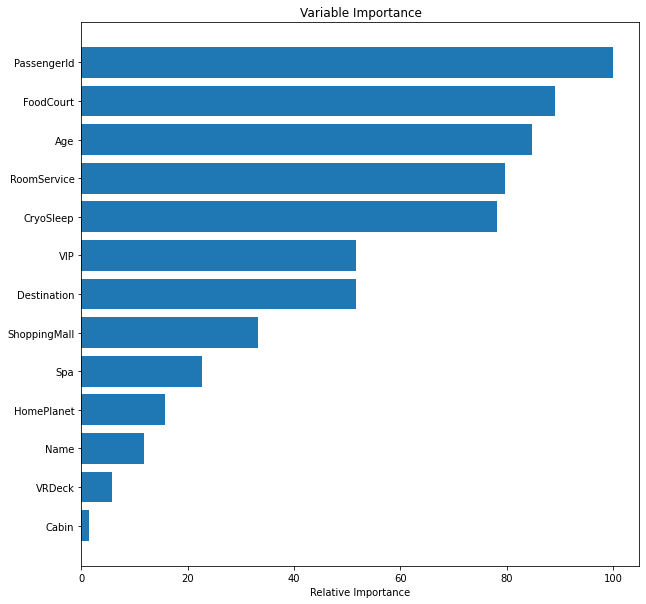

##############################################################################


In [29]:
pred= mod.creating_model(10, 'Classification', 10, cats_train, target, 'accuracy', cats_test)

In [30]:
pred

array([ True, False,  True, ...,  True,  True,  True])

In [34]:
submission = pd.DataFrame()
submission['PassengerId'] = test.PassengerId
submission['Transported'] = pred.astype('bool')
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [41]:
train

,ID,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,Male,2,2010-08-21,1,Saloon,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,Entity,20,2010-08-29,3,Saloon,NaN,NaN,Lagos,Lagos,Muuve,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12074,ID_ZZA1SES,Female,30,2010-05-25,1,Saloon,Black,Range Rover,Ibeju/Lekki,Ibeju-Lekki,Car Classic,1
12075,ID_ZZDAC3K,Female,59,2010-10-03,1,Saloon,NaN,NaN,NaN,NaN,Car Classic,0
12076,ID_ZZIU2XC,Male,34,2010-10-10,1,Saloon,NaN,NaN,NaN,NaN,CarSafe,0
12077,ID_ZZRQ1NF,Male,120,2010-02-27,2,Saloon,White,TOYOTA,Victoria Island,Lagos,CVTP,0


In [42]:
test

,ID,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,Female,46,2010-10-23,1,Saloon,Black,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,Male,32,2010-10-14,1,Saloon,Black,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,Female,58,2010-06-13,1,Saloon,Black,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,Male,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic
...,...,...,...,...,...,...,...,...,...,...,...
1197,ID_ZTTHC5X,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic
1198,ID_ZUJAFUP,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic
1199,ID_ZWHCTUM,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP
1200,ID_ZWQRL8L,Male,44,2010-02-16,2,Saloon,Black,Nissan,Aba North,Aba-North,Car Classic
